![alt text](../img/general/header_workflow.png)

## High-Level Synthesis for Machine Learning (hls4ml)

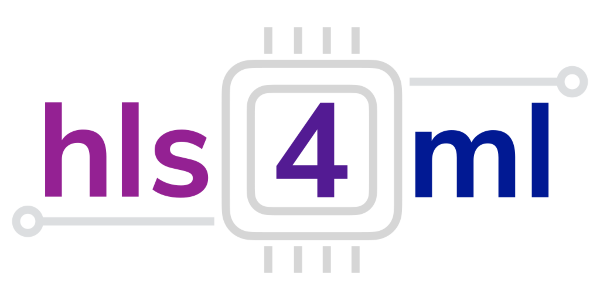

**High-Level Synthesis for Machine Learning (hls4ml)** is an open-source library designed to convert machine learning models into hardware-optimized descriptions for FPGA implementation.

### Key Features of hls4ml

- Converts models from **Keras, TensorFlow, PyTorch, and ONNX** into **HLS (High-Level Synthesis)** projects.
- Uses tools such as **Xilinx Vitis HLS** and the **Intel HLS Compiler** to generate hardware-optimized C++ code.
- Enables reduced latency and power consumption, improving efficiency for **edge AI** deployments.
- Supports **quantization** and **pruning** techniques to reduce model size without significantly impacting accuracy.

### Applications of hls4ml

- Real-time processing in embedded systems.
- Deployment of neural networks on low-power hardware.
- Acceleration of AI models in applications such as **particle physics**, **computer vision**, and **robotics**.

### More Information

- GitHub: https://github.com/fastmachinelearning/hls4ml  
- Website: https://fastmachinelearning.org/hls4ml/


---

### Libraries

In [6]:
import os
import numpy as np
import tensorflow as tf 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from qkeras import *
from qkeras import QActivation
from qkeras import QDense, QConv2DBatchnorm
import hls4ml
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.datasets import mnist

### Path to Vitis HLS


As an initial step, the installation directory of Vivado HLS or Vitis HLS must be specified so that the tools are available in the system PATH.

In [ ]:

# Path where Vitis HLS is installed
# os.environ['PATH'] = '/tools/Xilinx/XilinxUnified_2022/Vitis_HLS/2022.2/bin:' + os.environ['PATH']

# For VIRTUAL MACHINE setups
os.environ['PATH'] = '/tools/Xilinx/Vitis_HLS/2022.2/bin:' + os.environ['PATH']

# Verify updated PATH
os.environ['PATH']

'/tools/Xilinx/Vitis_HLS/2022.2/bin:/tools/Xilinx/Vitis_HLS/2022.2/bin:/tools/anaconda3/envs/neuralEnv/bin:/tools/anaconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin'

### Loading pre-trained model (.h5)

Carga del modelo pre-entrenado y guardado en formato **.h5**. 

Para este laboratorio, el modelo fue generado en el **lab03**.

In [8]:
from qkeras.utils import _add_supported_quantized_objects

# Register QKeras quantized objects required to load quantized models
co = {}
_add_supported_quantized_objects(co)

# Load the quantized (QAP) MNIST binary classification model
model = load_model('model/mnistQAP-1-9-binary.h5', custom_objects=co)

# Display a summary of the model architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1_input (QDense)          (None, 5)                 3925      
                                                                 
 relu_input (QActivation)    (None, 5)                 0         
                                                                 
 fc1 (QDense)                (None, 7)                 42        
                                                                 
 relu1 (QActivation)         (None, 7)                 0         
                                                                 
 fc2 (QDense)                (None, 10)                80        
                                                                 
 relu2 (QActivation)         (None, 10)                0         
                                                                 
 output (QDense)             (None, 2)                 2

**Note:** When loading models trained with QKeras, it is necessary to register the custom quantized layers and activations using *custom_objects*.
This ensures that Keras correctly reconstructs the quantized model during loading.

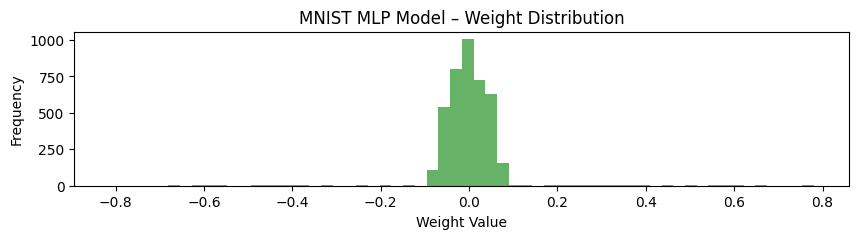

In [9]:
# Weight distribution analysis

# Weight distributions provide insight into model sparsity and dynamic range, 
# which are key factors when selecting quantization bit-widths and fixed-point formats for hardware synthesis.

# Collect and flatten all model weights into a single array
weights = np.concatenate([w.flatten() for w in model.get_weights()])

# Plot the weight distribution
plt.figure(figsize=(10, 2))
plt.hist(weights, bins=60, color='green', alpha=0.6)

plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.title("MNIST MLP Model – Weight Distribution")
plt.show()


### hls4ml 

Arbitrary precision reference: https://docs.amd.com/r/2022.2-English/ug1399-vitis-hls/Fixed-Point-Identifier-Summary?tocId=jgeN4rPFF_M6nxbDn1H5HA

In [10]:
# Generate the hls4ml configuration dictionary from the Keras model
# Using 'granularity="name"' creates configuration entries per layer name
hls_config = hls4ml.utils.config_from_keras_model(
    model,
    granularity='name'
)

import plotting

# Print the generated hls4ml configuration
print("-----------------------------------")
plotting.print_dict(hls_config)
print("-----------------------------------")


Interpreting Sequential
Topology:
Layer name: fc1_input_input, layer type: InputLayer, input shapes: [[None, 784]], output shape: [None, 784]
Layer name: fc1_input, layer type: QDense, input shapes: [[None, 784]], output shape: [None, 5]
Layer name: relu_input, layer type: Activation, input shapes: [[None, 5]], output shape: [None, 5]
Layer name: fc1, layer type: QDense, input shapes: [[None, 5]], output shape: [None, 7]
Layer name: relu1, layer type: Activation, input shapes: [[None, 7]], output shape: [None, 7]
Layer name: fc2, layer type: QDense, input shapes: [[None, 7]], output shape: [None, 10]
Layer name: relu2, layer type: Activation, input shapes: [[None, 10]], output shape: [None, 10]
Layer name: output, layer type: QDense, input shapes: [[None, 10]], output shape: [None, 2]
Layer name: sigmoid, layer type: Activation, input shapes: [[None, 2]], output shape: [None, 2]
-----------------------------------
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Strategy

The **hls_config** dictionary defines hardware-related parameters such as numerical precision, reuse factor, and strategy for each layer.
Using **granularity='name'** allows fine-grained control over individual layers, which is especially useful for optimization and hardware exploration.

In [23]:
from hls4ml.model.profiling import numerical, get_ymodel_keras

# NOTE:
# Layer names may differ depending on the model definition.
# Always check the keys in hls_config['LayerName'] before editing.

# Set fixed-point precision for specific layers (per-layer control)
hls_config['LayerName']['fc1_input_input']['Precision'] = 'ap_fixed<16, 6>'  # input layer precision
hls_config['LayerName']['fc1_input']['Precision'] = 'ap_fixed<8, 2>'         # first dense layer precision

hls_config['LayerName']['relu_input']['Precision'] = 'ap_fixed<8, 3>'        # activation layer precision

# Use a numerically stable implementation for the sigmoid operation
hls_config['LayerName']['sigmoid']['Strategy'] = 'Stable'

# Set the default model-wide precision (used unless overridden per layer)
hls_config['Model']['Precision'] = 'ap_fixed<16, 6>'


### hls4ml with Vitis HLS as backend

In [24]:
# Create an hls4ml conversion configuration for the Vitis backend
cfg = hls4ml.converters.create_config(backend='Vitis')

# Optional: set the I/O interface type
# Use 'io_stream' typically for CNNs and streaming designs
# cfg['IOType'] = 'io_stream'

# Assign the hls4ml configuration dictionary (precision, reuse factors, strategies, etc.)
cfg['HLSConfig'] = hls_config

# Provide the trained Keras model to be converted
cfg['KerasModel'] = model

# Output directory where the HLS project will be generated
cfg['OutputDir'] = 'hlsPrj/student_qap_final'

# Target FPGA part
# PYNQ-Z1 / ZedBoard: xc7z020clg484-1
# Artix-7 example:    xc7a35tcsg325-1
# MPSoC examples:     xczu4eg-sfvc784-2-e, xczu3eg-sfvc784-1-e
cfg['Part'] = 'xc7z020clg484-1'

# Convert the Keras model into an hls4ml HLS project
hls_model = hls4ml.converters.keras_to_hls(cfg)

# Compile the hls4ml model (build internal graph, prepare for prediction/synthesis)
hls_model.compile()


Interpreting Sequential
Topology:
Layer name: fc1_input_input, layer type: InputLayer, input shapes: [[None, 784]], output shape: [None, 784]
Layer name: fc1_input, layer type: QDense, input shapes: [[None, 784]], output shape: [None, 5]
Layer name: relu_input, layer type: Activation, input shapes: [[None, 5]], output shape: [None, 5]
Layer name: fc1, layer type: QDense, input shapes: [[None, 5]], output shape: [None, 7]
Layer name: relu1, layer type: Activation, input shapes: [[None, 7]], output shape: [None, 7]
Layer name: fc2, layer type: QDense, input shapes: [[None, 7]], output shape: [None, 10]
Layer name: relu2, layer type: Activation, input shapes: [[None, 10]], output shape: [None, 10]
Layer name: output, layer type: QDense, input shapes: [[None, 10]], output shape: [None, 2]
Layer name: sigmoid, layer type: Activation, input shapes: [[None, 2]], output shape: [None, 2]
Creating HLS model
Writing HLS project


Done


bash: /tools/anaconda3/envs/neuralEnv/lib/libtinfo.so.6: no version information available (required by bash)


67/67 [==============================] - 0s 743us/step


<Figure size 500x400 with 0 Axes>

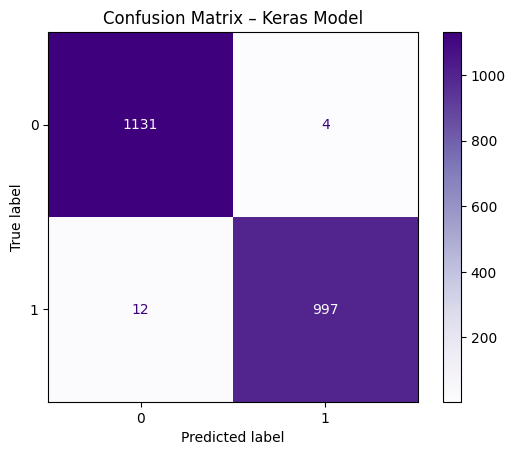

<Figure size 500x400 with 0 Axes>

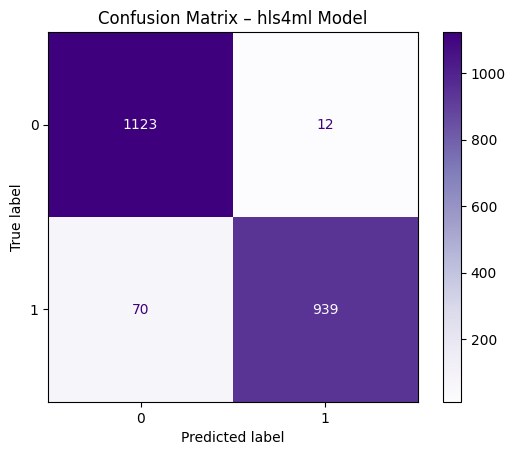

In [25]:
# Load the MNIST dataset, split into training and testing sets (data and labels)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize pixel values to the range [0, 1]
x_test_norm = x_test / 255.0

# Select only samples with labels 1 and 9
mask_test  = (y_test == 1) | (y_test == 9)

x_test_bin = x_test_norm[mask_test]
y_test_bin = y_test[mask_test]

# Map labels: 1 -> 0, 9 -> 1
y_test_bin  = (y_test_bin == 9).astype(int)

# Flatten images to match model input (784,)
x_test_bin  = x_test_bin.reshape(-1, 28 * 28)

# -----------------------------
# Keras model inference
# -----------------------------
y_pred_keras_probs = model.predict(x_test_bin)
y_pred_keras = np.argmax(y_pred_keras_probs, axis=1)

# Ground-truth labels (convert from one-hot if needed)
y_true = np.argmax(y_test_bin, axis=1) if y_test_bin.ndim > 1 else y_test_bin

cm_keras = confusion_matrix(y_true, y_pred_keras)

plt.figure(figsize=(5, 4))
ConfusionMatrixDisplay(confusion_matrix=cm_keras).plot(cmap="Purples")
plt.title("Confusion Matrix – Keras Model")
plt.show()

# -----------------------------
# hls4ml model inference
# -----------------------------
# hls_model.predict expects numpy arrays and returns probabilities
y_pred_hls_probs = hls_model.predict(x_test_bin)
y_pred_hls = np.argmax(y_pred_hls_probs, axis=1)


cm_hls = confusion_matrix(y_true, y_pred_hls)

plt.figure(figsize=(5, 4))
ConfusionMatrixDisplay(confusion_matrix=cm_hls).plot(cmap="Purples")
plt.title("Confusion Matrix – hls4ml Model")
plt.show()


In [ ]:
# Build the hls4ml project
# csim=False  → Skip C simulation
# export=False → Do not export the project as a packaged archive
# hls_model.build(csim=False, export=False)


The *build()* step generates the HLS project, synthesizable C++ code, and reports.
Disabling C simulation (csim=False) speeds up the build process when functional validation is not required at this stage.

----

#### Exercise

- Run the **HLS synthesis** process for different models trained with different **compression techniques**, and compare the obtained results in terms of **latency** and **resource utilization**.  
  What conclusions can you draw when linking the generated hardware to the compression technique applied?

  Consider **MNIST** or **Fashion-MNIST**, using an **MLP architecture** (**without a `Flatten` layer as the first layer**). Evaluate the following cases:

  - **Pruning + Quantization** (8-bit)
  - **Quantization only** (16-bit)
  - **Knowledge Distillation** (teacher–student approach)
